In [1]:
# Kütüphaneleri içe aktaralım
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback # Eğitim sırasında ilerleme çubuğu ekleme
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Kaggle API ayarları
from google.colab import files
files.upload()  # kaggle.json dosyasını buradan yükleyin

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Veri setini indirme
!kaggle datasets download -d omkargurav/face-mask-dataset
!unzip face-mask-dataset.zip -d face-mask-dataset


Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: face-mask-dataset/data/with_mask/with_mask_3297.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3298.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3299.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_33.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_330.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3300.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3301.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3302.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3303.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3304.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3305.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3306.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3307.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3308.jpg  
  inflating: face-

In [3]:
import os
print(os.listdir("face-mask-dataset"))

['data']


In [4]:
import os
import shutil
import random

# Veri setinin yolu
DATA_DIR = "face-mask-dataset/data"
TEST_DIR = "face-mask-dataset/test"

# Yeni test klasörünü oluştur
os.makedirs(TEST_DIR, exist_ok=True)

# Sınıflar
categories = ["with_mask", "without_mask"]

# Her sınıf için test verisini taşı
for category in categories:
    category_path = os.path.join(DATA_DIR, category)
    test_category_path = os.path.join(TEST_DIR, category)

    os.makedirs(test_category_path, exist_ok=True)  # Test klasörünü oluştur

    # Tüm dosyaları al ve karıştır
    images = os.listdir(category_path)
    random.shuffle(images)

    # %20'sini test için ayır
    test_size = int(0.2 * len(images))
    test_images = images[:test_size]

    # Dosyaları taşı
    for image in test_images:
        src = os.path.join(category_path, image)
        dst = os.path.join(test_category_path, image)
        shutil.move(src, dst)

print("✅ Test verisi başarıyla ayrıldı!")


✅ Test verisi başarıyla ayrıldı!


In [5]:
# Eğitim ve test bölme (%80 eğitim + validasyon, %20 test)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

TEST_DIR = "face-mask-dataset/test"

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4835 images belonging to 2 classes.
Found 1208 images belonging to 2 classes.
Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [6]:
# DenseNet121 modeli
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout oranını azalttık
x = Dense(128, activation='relu')(x)  # Daha sade bir yapı
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Modeli derleme
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),  # Daha uygun başlangıç öğrenme oranı
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [7]:
# Modelin yeniden kullanımı !!! Aşağıda yeniden eğitimi mevcut. Best modeli tekrar kullanınız.
from tensorflow.keras.models import load_model

try:
    model = load_model('best_model.keras')
    print("✅ Model başarıyla yüklendi!")
except Exception as e:
    print(f"❌ Model yüklenirken hata oluştu: {e}")

✅ Model başarıyla yüklendi!


Model eğitimi tamamlandığı için ve best model olarak değeri aldığım için aşağıdaki eğitim kodunu kapattım.

In [10]:

'''
# Callbacks (erken durdurma ve öğrenme oranı azaltma mekanizması)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Sınıf ağırlıklarını hesaplayalım (veri dengesizse kullanılır)
class_weights = {0: 1.0, 1: 1.2}  # Eğer sınıflar eşit değilse bu değerleri güncelle


# Model eğitimi
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[checkpoint, early_stopping, reduce_lr, TqdmCallback()],
    class_weight=class_weights  # Veri dengesizliğini gidermek için ekledik
)

'''

"\n# Callbacks (erken durdurma ve öğrenme oranı azaltma mekanizması)\ncheckpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)\nearly_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)\nreduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)\n\n# Sınıf ağırlıklarını hesaplayalım (veri dengesizse kullanılır)\nclass_weights = {0: 1.0, 1: 1.2}  # Eğer sınıflar eşit değilse bu değerleri güncelle\n\n\n# Model eğitimi\nhistory = model.fit(\n    train_generator,\n    validation_data=validation_generator,\n    epochs=100,\n    callbacks=[checkpoint, early_stopping, reduce_lr, TqdmCallback()],\n    class_weight=class_weights  # Veri dengesizliğini gidermek için ekledik\n)\n\n"

In [8]:
# Ortak dosya var mı? (Test datasının train datasıyla karışmasının kontrolü)
train_files = set(train_generator.filepaths)
test_files = set(test_generator.filepaths)
ortak_dosyalar = train_files & test_files
print("Ortak dosyalar var mı?", bool(ortak_dosyalar))


Ortak dosyalar var mı? False


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 345ms/step


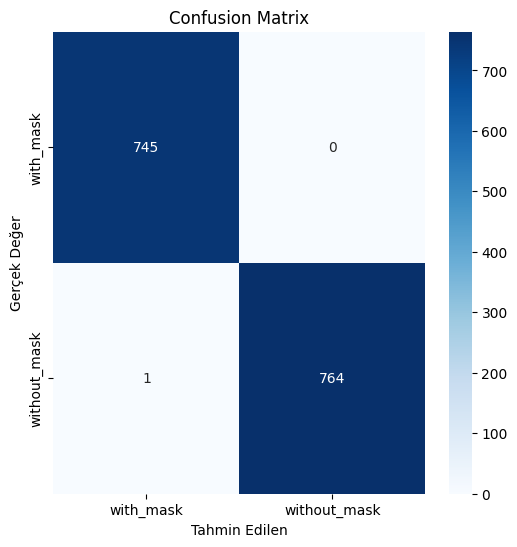

Sınıflandırma Raporu:
              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       745
without_mask       1.00      1.00      1.00       765

    accuracy                           1.00      1510
   macro avg       1.00      1.00      1.00      1510
weighted avg       1.00      1.00      1.00      1510



In [9]:
# Confusion Matrix ve Classification Report
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.title("Confusion Matrix")
plt.show()

print("Sınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=categories))


In [10]:
# Modeli değerlendir
test_loss, test_acc = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 209ms/step - accuracy: 0.9996 - loss: 0.0016
Test Loss: 0.0025
Test Accuracy: 0.9993


**Rastgele maskeli/maskesiz görsellerle modeli test etme işlemi yapıyorum.**


In [11]:
#

import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing import image

# Test edilecek görsellerin bulunduğu klasör
test_image_folder = "/content/ModelDenemeGorselleri"  # Görseller bu klasörde olmalı (Ödev içerisinde mevcut.)

# Modelin giriş boyutu
IMG_SIZE = (224, 224)  # Modeline uygun şekilde değiştir

# Sınıf isimleri
class_names = ["with_mask", "without_mask"]

# Görselleri sırayla test et
for img_name in os.listdir(test_image_folder):
    img_path = os.path.join(test_image_folder, img_name)

    # Görseli yükle ve işleme al
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Modelin beklediği formata getir
    img_array /= 255.0  # Normalizasyon (modelin eğitim şekline göre değişebilir)

    # Tahmini yap
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Sonucu yazdır
    print(f"{img_name} -> Tahmin: {class_names[predicted_class]} ({prediction[0][predicted_class]:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
TestIcinRastelegeResim_Maskesiz_2.jpg -> Tahmin: without_mask (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
TestIcinRastelegeResim_2.jpg -> Tahmin: with_mask (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
TestIcinRastelegeResim_1.jpg -> Tahmin: with_mask (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
TestIcinRastelegeResim_Maskesiz_1.jpg -> Tahmin: without_mask (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
TestIcinRastelegeResim_Maskesiz_3.jpg -> Tahmin: without_mask (1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
TestIcinRastelegeResim_3.jpg -> Tahmin: with_mask (1.00)


**RAPORLAMA AŞAMASI**

ROC Eğrisi ve AUC Hesaplama

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step


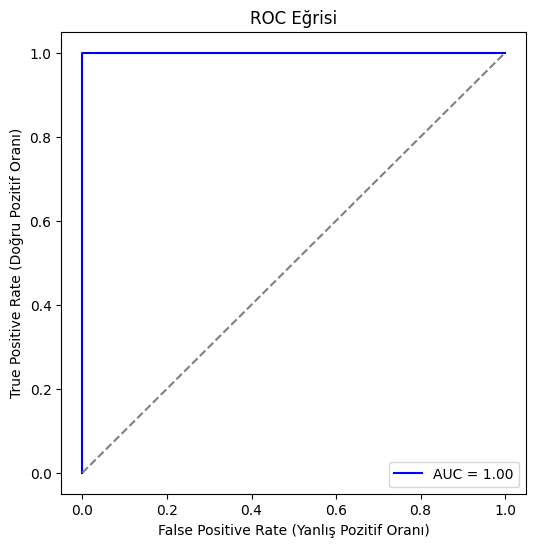

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Tahmin edilen olasılıklar (probability)
y_pred_prob = model.predict(test_generator)

# Gerçek etiketler
y_true = test_generator.classes

# Sadece bir sınıf için ROC eğrisi çiziyoruz (binary classification)
fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# ROC Eğrisi çizme
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Rastgele tahmin çizgisi
plt.xlabel('False Positive Rate (Yanlış Pozitif Oranı)')
plt.ylabel('True Positive Rate (Doğru Pozitif Oranı)')
plt.title('ROC Eğrisi')
plt.legend(loc='lower right')
plt.show()


Confusion Matrix Çizme

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step


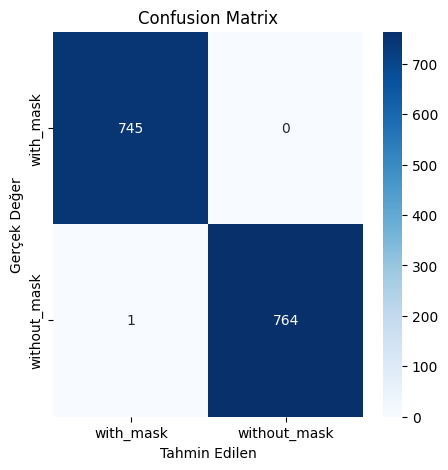

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Modelin tahminlerini al
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix hesapla
cm = confusion_matrix(y_true, y_pred_classes)

# Çizme
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["with_mask", "without_mask"], yticklabels=["with_mask", "without_mask"])
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.title("Confusion Matrix")
plt.show()


Accuracy, Precision, Recall, Specificity ve F1-score

In [14]:
from sklearn.metrics import classification_report

# Precision, Recall, F1-score hesapla
report = classification_report(y_true, y_pred_classes, target_names=["with_mask", "without_mask"])
print(report)


              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       745
without_mask       1.00      1.00      1.00       765

    accuracy                           1.00      1510
   macro avg       1.00      1.00      1.00      1510
weighted avg       1.00      1.00      1.00      1510



Specificity Hesaplama

In [15]:
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.2f}")

Specificity: 1.00
